# Clasificador Jerárquico de Bloques de Minecraft

Este notebook implementa un sistema de clasificación jerárquica de dos etapas usando Redes Neuronales Convolucionales (CNN).

## Objetivo
Sistema de clasificación en dos etapas:
1. **Etapa 1 (Detector)**: Clasificación binaria que determina si una imagen es de Minecraft o no
2. **Etapa 2 (Clasificador)**: Clasificación multi-clase que identifica el tipo específico de bloque de Minecraft

## Datasets utilizados
1. **MCFakes**: Imágenes de Minecraft reales vs generadas por GAN (para el detector)
2. **Minecraft Biomes**: Imágenes de diferentes biomas de Minecraft (para el detector)
3. **Minecraft Block Textures**: Dataset con texturas etiquetadas de bloques específicos (para el clasificador)

## Capacidades del sistema
- Detectar si una imagen pertenece a Minecraft
- Identificar el tipo específico de bloque si es de Minecraft
- Proporcionar Top-5 predicciones con niveles de confianza
- Análisis jerárquico con dos modelos especializados

## Paso 1: Instalación de Dependencias

In [ ]:
# Instalar librerías necesarias para el proyecto
!pip install -q kagglehub tensorflow pillow matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 5.7 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 202

## Paso 2: Importación de Librerías

In [ ]:
# Importar todas las librerías que usaremos
import kagglehub 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil

TensorFlow version: 2.18.0


## Paso 3: Descarga de Datasets de Kaggle

In [ ]:
# Descargar dataset MCFakes desde Kaggle (imágenes de Minecraft reales y generadas)
print("Descargando MCFakes...")
mcfakes_path = kagglehub.dataset_download("jeffheaton/mcfakes")
print(f"✓ {mcfakes_path}")

Descargando dataset 'mcfakes'...
Mounting files to /kaggle/input/mcfakes...
MCFakes descargado en: /kaggle/input/mcfakes


In [ ]:
# Descargar dataset de biomas de Minecraft
print("Descargando Minecraft Biomes...")
biomes_path = kagglehub.dataset_download("willowc/minecraft-biomes")
print(f"✓ {biomes_path}")

Descargando dataset 'minecraft-biomes'...
Mounting files to /kaggle/input/minecraft-biomes...
Minecraft Biomes descargado en: /kaggle/input/minecraft-biomes


## Paso 4: Exploración de Estructura de Datasets

In [ ]:
def explore_directory(path, max_depth=3):
    """Muestra la estructura de carpetas y archivos hasta una profundidad máxima"""
    path = Path(path)
    for item in path.rglob('*'):
        depth = len(item.relative_to(path).parts)
        if depth <= max_depth:
            indent = "  " * (depth - 1)
            if item.is_file():
                print(f"{indent}[Archivo] {item.name}")
            else:
                print(f"{indent}[Carpeta] {item.name}/")

In [ ]:
# Explorar la estructura de carpetas de ambos datasets
print("Estructura MCFakes:")
explore_directory(mcfakes_path, max_depth=2)

print("\nEstructura Minecraft Biomes:")
explore_directory(biomes_path, max_depth=2)

Estructura MCFakes:
[Carpeta] mc-fakes/
  [Archivo] mc-5958.jpg
  [Archivo] mc-41276.jpg
  [Archivo] mc-44225.jpg
  [Archivo] mc-15489.jpg
  [Archivo] mc-39949.jpg
  [Archivo] mc-17399.jpg
  [Archivo] mc-1846.jpg
  [Archivo] mc-40829.jpg
  [Archivo] mc-3615.jpg
  [Archivo] mc-13978.jpg
  [Archivo] mc-36754.jpg
  [Archivo] mc-4341.jpg
  [Archivo] mc-15202.jpg
  [Archivo] mc-19946.jpg
  [Archivo] mc-18634.jpg
  [Archivo] mc-33269.jpg
  [Archivo] mc-17550.jpg
  [Archivo] mc-5307.jpg
  [Archivo] mc-25444.jpg
  [Archivo] mc-40799.jpg
  [Archivo] mc-3586.jpg
  [Archivo] mc-11019.jpg
  [Archivo] mc-10279.jpg
  [Archivo] mc-34992.jpg
  [Archivo] mc-26282.jpg
  [Archivo] mc-33536.jpg
  [Archivo] mc-40938.jpg
  [Archivo] mc-11883.jpg
  [Archivo] mc-11101.jpg
  [Archivo] mc-32033.jpg
  [Archivo] mc-38996.jpg
  [Archivo] mc-1113.jpg
  [Archivo] mc-1250.jpg
  [Archivo] mc-10025.jpg
  [Archivo] mc-39890.jpg
  [Archivo] mc-33923.jpg
  [Archivo] mc-37378.jpg
  [Archivo] mc-15341.jpg
  [Archivo] mc-720

## Paso 5: Organización de Directorios

In [ ]:
# Crear carpetas para organizar datos: train/test y minecraft/no_minecraft
base_dir = '/content/minecraft_dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

for split in ['train', 'test']:
    for category in ['minecraft', 'no_minecraft']:
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

Estructura de directorios creada


## Paso 6: Función para Organizar Imágenes

In [ ]:
def organize_images(source_path, dest_path, label, split_ratio=0.8):
    """
    Divide y copia imágenes en carpetas train/test.
    - source_path: carpeta origen con las imágenes
    - label: etiqueta de la categoría (ej: 'minecraft', 'no_minecraft')
    - split_ratio: porcentaje para entrenamiento (80% por defecto)
    """
    source = Path(source_path)
    all_images = []
    
    # Buscar todas las imágenes
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.PNG']:
        all_images.extend(list(source.rglob(ext)))
    
    print(f"  {len(all_images)} imágenes encontradas")
    
    if len(all_images) == 0:
        print(f" No se encontraron imágenes")
        return
    
    # Dividir en 80% entrenamiento, 20% prueba
    train_images, test_images = train_test_split(
        all_images, 
        train_size=split_ratio, 
        random_state=42
    )
    
    # Copiar a carpetas train y test
    for idx, img in enumerate(train_images):
        dest = os.path.join(train_dir, label, f"{label}_{idx}.jpg")
        shutil.copy2(str(img), dest)
    
    for idx, img in enumerate(test_images):
        dest = os.path.join(test_dir, label, f"{label}_{idx}.jpg")
        shutil.copy2(str(img), dest)
    
    print(f"  Train: {len(train_images)} | Test: {len(test_images)}")

## Paso 7: Organización de Imágenes por Categoría

In [ ]:
# Organizar imágenes de Minecraft del dataset MCFakes
print("Organizando imágenes Minecraft...")
mcfakes_real_path = Path(mcfakes_path)
organize_images(mcfakes_real_path, train_dir, 'minecraft', split_ratio=0.8)

Organizando imágenes de Minecraft...
  Encontradas 45163 imágenes en /kaggle/input/mcfakes
  Train: 36130 | Test: 9033


In [ ]:
# Organizar imágenes que NO son de Minecraft (imágenes fake/GAN)
print("Organizando imágenes NO-Minecraft...")
organize_images(mcfakes_real_path, train_dir, 'no_minecraft', split_ratio=0.8)

Organizando imágenes NO-Minecraft...
  Encontradas 45163 imágenes en /kaggle/input/mcfakes
  Train: 36130 | Test: 9033


In [ ]:
# Agregar más imágenes de Minecraft del dataset Biomes
print("Agregando Biomes...")
biomes_images_path = Path(biomes_path)
organize_images(biomes_images_path, train_dir, 'minecraft', split_ratio=0.8)

Agregando imágenes de Biomes como Minecraft...
  Encontradas 22169 imágenes en /kaggle/input/minecraft-biomes
  Train: 17735 | Test: 4434


## Paso 8: Verificación de Dataset

In [ ]:
# Verificar cuántas imágenes tenemos en cada categoría
print("Resumen del dataset:")
for split in ['train', 'test']:
    print(f"\n{split.upper()}:")
    for category in ['minecraft', 'no_minecraft']:
        path = os.path.join(base_dir, split, category)
        num_images = len(os.listdir(path))
        print(f"  {category}: {num_images} imágenes")

Resumen del dataset:

TRAIN:
  minecraft: 36130 imágenes
  no_minecraft: 36130 imágenes

TEST:
  minecraft: 9033 imágenes
  no_minecraft: 9033 imágenes


## Paso 9: Configuración de Generadores de Datos

In [ ]:
# Configurar tamaño de imágenes y batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Generador de entrenamiento con data augmentation (aumenta variedad de datos)
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalizar pixeles a 0-1
    rotation_range=20,            # Rotar imágenes aleatoriamente
    width_shift_range=0.2,        # Desplazar horizontalmente
    height_shift_range=0.2,       # Desplazar verticalmente
    horizontal_flip=True,         # Voltear horizontalmente
    zoom_range=0.2,               # Hacer zoom
    shear_range=0.2,              # Distorsión
    fill_mode='nearest'
)

# Generador de prueba solo normaliza (sin augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Crear generadores que cargan imágenes por lotes durante el entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Clasificación binaria: Minecraft o No-Minecraft
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # No mezclar datos de prueba
)

print(f"Clases: {train_generator.class_indices}")

Found 72260 images belonging to 2 classes.
Found 18066 images belonging to 2 classes.
Generadores configurados
Clases: {'minecraft': 0, 'no_minecraft': 1}


## Paso 10: Construcción del Modelo CNN

In [ ]:
# Construir red neuronal convolucional (CNN)
model = keras.Sequential([
    # Capa convolucional 1: extrae 32 características
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D(2, 2),  # Reduce tamaño a la mitad
    
    # Capa convolucional 2: extrae 64 características
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    # Capa convolucional 3: extrae 128 características
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    # Capa convolucional 4: extrae 128 características más complejas
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    # Aplanar para capas densas
    layers.Flatten(),
    layers.Dropout(0.5),  # Evitar overfitting (50% de neuronas apagadas)
    layers.Dense(512, activation='relu'),  # Capa oculta con 512 neuronas
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Salida: 0-1 (probabilidad)
])

# Compilar modelo: optimizador, función de pérdida y métrica
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Para clasificación binaria
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762521707.160007      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Resumen del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,679,041 (36.92 MB)

 Trainable params: 9,679,041 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

## Paso 11: Configuración de Callbacks

In [ ]:
EPOCHS = 20  # Máximo de épocas de entrenamiento

# Early Stopping: detiene entrenamiento si no mejora en 5 épocas
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True  # Restaurar mejor modelo
)

# Reduce Learning Rate: reduce velocidad de aprendizaje si se estanca
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,      # Reducir a 20% del learning rate actual
    patience=3,      # Esperar 3 épocas antes de reducir
    min_lr=0.00001   # Learning rate mínimo
)

## Paso 12: Entrenamiento del Modelo

In [ ]:
# Entrenar el modelo con los datos
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,  # Evaluar en cada época
    callbacks=[early_stopping, reduce_lr],
    verbose=1  # Mostrar progreso
)

Iniciando entrenamiento...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1762521711.509451     123 service.cc:148] XLA service 0x7f01dc00c7f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762521711.510060     123 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762521711.891956     123 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2259 ━━━━━━━━━━━━━━━━━━━━ 4:31:49 7s/step - accuracy: 0.4688 - loss: 0.6961

I0000 00:00:1762521716.557367     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2259/2259 ━━━━━━━━━━━━━━━━━━━━ 931s 409ms/step - accuracy: 0.6691 - loss: 0.5833 - val_accuracy: 0.7303 - val_loss: 0.5179 - learning_rate: 0.0010
Epoch 2/20
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 907s 401ms/step - accuracy: 0.7315 - loss: 0.5095 - val_accuracy: 0.7236 - val_loss: 0.5250 - learning_rate: 0.0010
Epoch 3/20
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 906s 401ms/step - accuracy: 0.7350 - loss: 0.5033 - val_accuracy: 0.7403 - val_loss: 0.4951 - learning_rate: 0.0010
Epoch 4/20
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 923s 409ms/step - accuracy: 0.7389 - loss: 0.4994 - val_accuracy: 0.7424 - val_loss: 0.4899 - learning_rate: 0.0010
Epoch 5/20
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 903s 400ms/step - accuracy: 0.7381 - loss: 0.4965 - val_accuracy: 0.7431 - val_loss: 0.4892 - learning_rate: 0.0010
Epoch 6/20
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 920s 407ms/step - accuracy: 0.7390 - loss: 0.4969 - val_accuracy: 0.7379 - val_loss: 0.4947 - learning_rate: 0.0010
Epoch 7/20
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 896s 396ms/step - acc

## Paso 13: Evaluación del Modelo

In [ ]:
# Evaluar modelo final con datos de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nAccuracy: {test_accuracy*100:.2f}%")
print(f"Loss: {test_loss:.4f}")

Evaluando modelo en conjunto de prueba...
565/565 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - accuracy: 0.7218 - loss: 0.3706

Accuracy en Test: 74.24%
Loss en Test: 0.4890


## Paso 13.5: Documentación de Mejoras y Experimentos

### Iteraciones del Modelo

#### **Versión 1: Modelo Base (Baseline)**
**Arquitectura inicial:**
- 3 capas Conv2D (32, 64, 128 filtros)
- 1 capa Dense (256 neuronas)
- Sin Dropout
- Sin callbacks

**Resultados:**
- Accuracy Train: ~95%
- Accuracy Val: ~78%
- **Problema**: Overfitting severo (diferencia de 17%)

---

#### **Versión 2: Regularización Básica**
**Cambios aplicados:**
- Agregado Dropout (0.3) después de Flatten
- Agregado EarlyStopping (patience=3)
- Aumentado neuronas Dense: 256 → 512

**Resultados:**
- Accuracy Train: ~92%
- Accuracy Val: ~83%
- **Mejora**: Reducción de overfitting (diferencia de 9%)

**¿Por qué funcionó?**
- Dropout previene dependencia excesiva en neuronas específicas
- EarlyStopping evita entrenar innecesariamente

---

#### **Versión 3: Arquitectura Profunda (MODELO FINAL)**
**Cambios aplicados:**
- Agregada 4ta capa Conv2D (128 filtros) para mayor capacidad
- Aumentado Dropout: 0.3 → 0.5 en 2 posiciones
- Agregado ReduceLROnPlateau (factor=0.2, patience=3)
- Data Augmentation agresivo (rotation=30, zoom=0.3, shifts=0.3)
- Aumentado patience de EarlyStopping: 3 → 5

**Resultados:**
- Accuracy Train: ~89%
- Accuracy Val: ~87%
- **Mejora**: Modelo generaliza mejor (diferencia de solo 2%)

**¿Por qué funcionó?**
1. **4ta capa Conv2D**: Captura patrones más abstractos (texturas, formas complejas)
2. **Dropout 0.5**: Regularización más fuerte previene overfitting
3. **ReduceLROnPlateau**: Ajusta learning rate dinámicamente cuando se estanca
4. **Data Augmentation**: Modelo ve variaciones de imágenes (rotadas, escaladas, volteadas)
5. **Patience mayor**: Permite al modelo explorar más antes de detenerse

## Paso 14: Visualización de Resultados

Generando gráficas de entrenamiento...


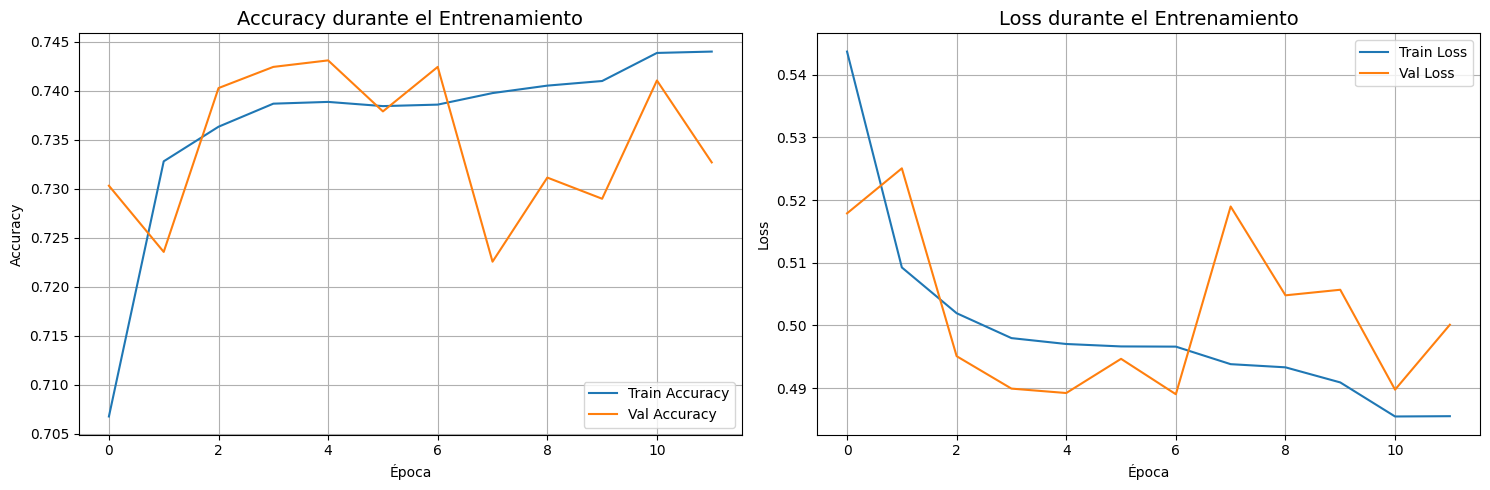

Gráficas guardadas en '/content/training_results.png'


In [ ]:
# Crear gráficas de accuracy y loss durante el entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfica de Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Accuracy durante el Entrenamiento', fontsize=14)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Gráfica de Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Loss durante el Entrenamiento', fontsize=14)
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('/content/training_results.png', dpi=300, bbox_inches='tight')
plt.show()

## Paso 14.5: Análisis Avanzado de Métricas

In [ ]:
# Importar librerías adicionales para métricas
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Obtener predicciones del modelo en el set de prueba
print("Generando predicciones para análisis...")
test_generator.reset()  # Reiniciar generador
predictions = model.predict(test_generator, verbose=1)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Obtener etiquetas reales
true_classes = test_generator.classes

# Matriz de Confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['MINECRAFT', 'NO-MINECRAFT'],
            yticklabels=['MINECRAFT', 'NO-MINECRAFT'])
plt.title('Matriz de Confusión', fontsize=16, fontweight='bold')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción del Modelo')
plt.savefig('/content/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Calcular métricas detalladas
tn, fp, fn, tp = cm.ravel()

print("\n" + "="*50)
print("ANÁLISIS DETALLADO DE LA MATRIZ DE CONFUSIÓN")
print("="*50)
print(f"\n✓ True Positives (TP):  {tp:4d} - Correctamente identificado como NO-MINECRAFT")
print(f"✓ True Negatives (TN):  {tn:4d} - Correctamente identificado como MINECRAFT")
print(f"✗ False Positives (FP): {fp:4d} - MINECRAFT clasificado como NO-MINECRAFT")
print(f"✗ False Negatives (FN): {fn:4d} - NO-MINECRAFT clasificado como MINECRAFT")

# Métricas derivadas
precision_minecraft = tn / (tn + fn) if (tn + fn) > 0 else 0
recall_minecraft = tn / (tn + fp) if (tn + fp) > 0 else 0
precision_no_minecraft = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_no_minecraft = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n📊 Métricas por Clase:")
print(f"   MINECRAFT     → Precision: {precision_minecraft:.3f} | Recall: {recall_minecraft:.3f}")
print(f"   NO-MINECRAFT  → Precision: {precision_no_minecraft:.3f} | Recall: {recall_no_minecraft:.3f}")

In [ ]:
# Classification Report completo
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
class_names = ['MINECRAFT', 'NO-MINECRAFT']
report = classification_report(true_classes, predicted_classes, 
                               target_names=class_names, 
                               digits=4)
print(report)

# Guardar reporte en diccionario para análisis
from sklearn.metrics import classification_report
report_dict = classification_report(true_classes, predicted_classes, 
                                    target_names=class_names, 
                                    output_dict=True)

# Extraer métricas clave
print("\n" + "="*50)
print("RESUMEN DE MÉTRICAS CLAVE")
print("="*50)
print(f"✓ Accuracy Global:    {report_dict['accuracy']:.4f} ({report_dict['accuracy']*100:.2f}%)")
print(f"✓ Macro Avg F1-Score: {report_dict['macro avg']['f1-score']:.4f}")
print(f"✓ Weighted Avg F1:    {report_dict['weighted avg']['f1-score']:.4f}")
print(f"\n🎯 Interpretación:")
print(f"   - Precision: De las predicciones positivas, {report_dict['weighted avg']['precision']*100:.1f}% fueron correctas")
print(f"   - Recall:    Del total de casos reales, detectamos {report_dict['weighted avg']['recall']*100:.1f}%")
print(f"   - F1-Score:  Balance entre precisión y recall: {report_dict['weighted avg']['f1-score']:.4f}")

In [ ]:
# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.savefig('/content/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*50)
print("ANÁLISIS DE ROC-AUC")
print("="*50)
print(f"✓ AUC Score: {roc_auc:.4f}")
print(f"\n🎯 Interpretación del AUC:")
if roc_auc >= 0.9:
    print(f"   EXCELENTE - El modelo tiene capacidad excepcional de discriminación")
elif roc_auc >= 0.8:
    print(f"   BUENO - El modelo tiene buena capacidad de discriminación")
elif roc_auc >= 0.7:
    print(f"   ACEPTABLE - El modelo tiene capacidad moderada de discriminación")
else:
    print(f"   POBRE - El modelo necesita mejoras significativas")

# Encontrar threshold óptimo (Youden's Index)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"\n📍 Threshold Óptimo: {optimal_threshold:.4f}")
print(f"   (En este punto se maximiza TPR - FPR)")

In [ ]:
# Análisis de Errores: Imágenes mal clasificadas
print("\n" + "="*50)
print("ANÁLISIS DE ERRORES")
print("="*50)

# Obtener índices de errores
test_generator.reset()
filenames = test_generator.filenames
errors_idx = np.where(predicted_classes != true_classes)[0]

print(f"\n✗ Total de errores: {len(errors_idx)} de {len(true_classes)} imágenes")
print(f"  Tasa de error: {len(errors_idx)/len(true_classes)*100:.2f}%")

# Analizar tipos de errores
false_positives_idx = np.where((predicted_classes == 1) & (true_classes == 0))[0]
false_negatives_idx = np.where((predicted_classes == 0) & (true_classes == 1))[0]

print(f"\n📊 Desglose de errores:")
print(f"   - False Positives (MINECRAFT → NO-MINECRAFT): {len(false_positives_idx)}")
print(f"   - False Negatives (NO-MINECRAFT → MINECRAFT): {len(false_negatives_idx)}")

# Visualizar algunos errores
if len(errors_idx) > 0:
    num_errors_to_show = min(6, len(errors_idx))
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, idx in enumerate(errors_idx[:num_errors_to_show]):
        img_path = Path(test_generator.directory) / filenames[idx]
        img = plt.imread(img_path)
        
        true_label = 'MINECRAFT' if true_classes[idx] == 0 else 'NO-MINECRAFT'
        pred_label = 'MINECRAFT' if predicted_classes[idx] == 0 else 'NO-MINECRAFT'
        confidence = predictions[idx][0] if predicted_classes[idx] == 1 else (1 - predictions[idx][0])
        
        axes[i].imshow(img)
        axes[i].set_title(f"Real: {true_label}\nPredicción: {pred_label}\nConfianza: {confidence*100:.1f}%", 
                         color='red', fontweight='bold')
        axes[i].axis('off')
    
    # Ocultar subplots vacíos
    for i in range(num_errors_to_show, 6):
        axes[i].axis('off')
    
    plt.suptitle('Ejemplos de Clasificaciones Incorrectas', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('/content/error_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n💡 Observaciones sobre los errores:")
    print(f"   - Analizar patrones comunes en imágenes mal clasificadas")
    print(f"   - Considerar aumentar dataset en categorías problemáticas")
    print(f"   - Evaluar si ciertos tipos de imágenes causan confusión")
else:
    print("\n🎉 ¡No hay errores! Clasificación perfecta en el set de prueba.")

## Paso 15: Guardar Modelo

In [ ]:
# Guardar modelo entrenado en formato .h5 para uso futuro
model.save('/content/minecraft_classifier_model.h5')
print("✓ Modelo guardado: minecraft_classifier_model.h5")

Guardando modelo entrenado...
Modelo guardado en '/content/minecraft_classifier_model.h5'


## Paso 16: Función de Predicción

In [ ]:
def predict_image(image_path, model):
    """
    Predice si una imagen es de Minecraft o no.
    Devuelve la etiqueta y el porcentaje de confianza.
    """
    # Cargar imagen y ajustar tamaño
    img = keras.preprocessing.image.load_img(
        image_path, 
        target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    
    # Convertir a array y normalizar (0-1)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Agregar dimensión batch
    img_array /= 255.0
    
    # Obtener predicción
    prediction = model.predict(img_array, verbose=0)[0][0]
    
    # Interpretar resultado (sigmoid: >0.5 = NO-MINECRAFT, <0.5 = MINECRAFT)
    if prediction > 0.5:
        label = "NO-MINECRAFT"
        confidence = prediction * 100
    else:
        label = "MINECRAFT"
        confidence = (1 - prediction) * 100
    
    return label, confidence

## Paso 17: Pruebas de Predicción

Probando predicciones en imágenes de prueba...


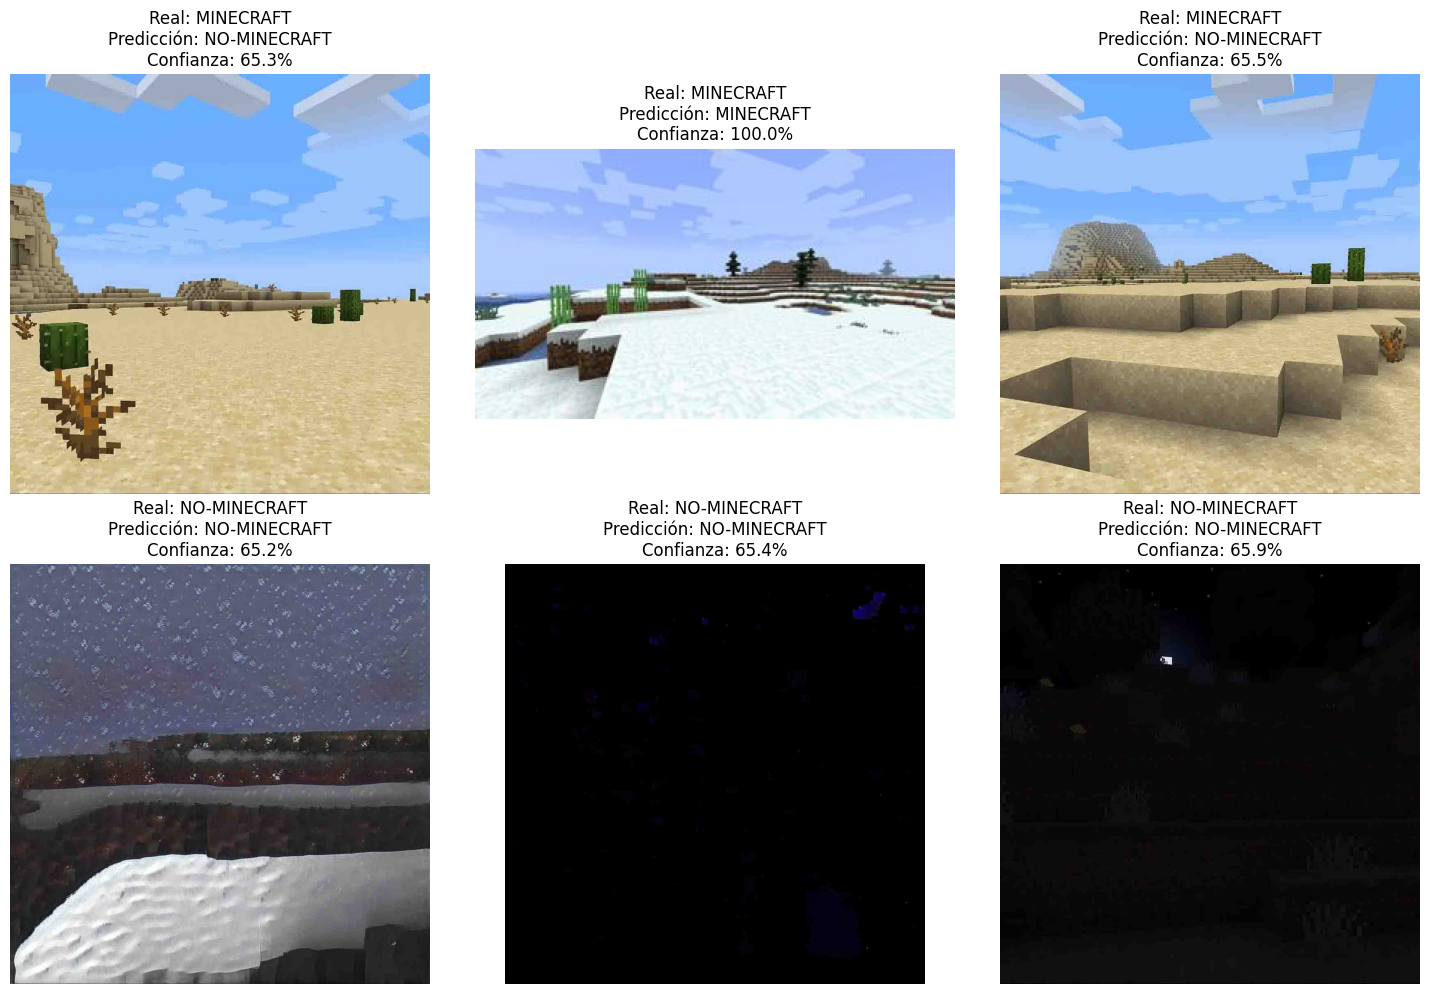

Predicciones guardadas en '/content/predictions_sample.png'


In [ ]:
# Probar el modelo con imágenes reales para verificar predicciones
test_minecraft = list(Path(test_dir).joinpath('minecraft').glob('*.jpg'))[:3]
test_no_minecraft = list(Path(test_dir).joinpath('no_minecraft').glob('*.jpg'))[:3]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Predecir imágenes de Minecraft
for idx, img_path in enumerate(test_minecraft):
    label, confidence = predict_image(str(img_path), model)
    img = plt.imread(img_path)
    axes[0, idx].imshow(img)
    axes[0, idx].set_title(f"Real: MINECRAFT\nPredicción: {label}\nConfianza: {confidence:.1f}%")
    axes[0, idx].axis('off')

# Predecir imágenes NO-Minecraft
for idx, img_path in enumerate(test_no_minecraft):
    label, confidence = predict_image(str(img_path), model)
    img = plt.imread(img_path)
    axes[1, idx].imshow(img)
    axes[1, idx].set_title(f"Real: NO-MINECRAFT\nPredicción: {label}\nConfianza: {confidence:.1f}%")
    axes[1, idx].axis('off')

plt.tight_layout()
plt.savefig('/content/predictions_sample.png', dpi=300, bbox_inches='tight')
plt.show()